In [1]:
import numpy as np
import cupy as cp
import cv2
import xraylib
from holotomocupy.utils import *

astropy module not found
olefile module not found


In [2]:
n = 1024  # object size in each dimension
pad = 0 # pad for the reconstructed probe
npos = 16 # total number of positions
z1 = 4.267e-3 # [m] position of the sample
detector_pixelsize = 3.0e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size

extra = 8
nobj = n+n//8
nprb = n+2*pad
npatch = nprb+2*extra

show = True
path = f'/data/vnikitin/paper/near_field'
path_out = f'/data/vnikitin/paper/near_field/rec0'
print(f'{voxelsize=},{distance=}')

voxelsize=np.float64(1.000078125e-08),distance=0.00425277555546875


In [3]:
def Lop(psi):
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(-1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff = cp.fft.ifft2(cp.fft.fft2(psi)*fP)
    ff = ff[:,pad:nprb-pad,pad:nprb-pad]
    return ff

def LTop(psi):
    fx = cp.fft.fftfreq(nprb, d=voxelsize).astype('float32')
    [fx, fy] = cp.meshgrid(fx, fx)
    fP = cp.exp(1j*cp.pi*wavelength*distance*(fx**2+fy**2))
    ff = cp.pad(psi,((0,0),(pad,pad),(pad,pad)))    
    ff = cp.fft.ifft2(cp.fft.fft2(ff)*fP)
    return ff

def Ex(psi,ix):
    res = cp.empty([ix.shape[0],npatch,npatch],dtype='complex64')
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        res[k] = psi[sty[k]:endy[k],stx[k]:endx[k]] 
    return res

def ExT(psi,psir,ix):
    stx = nobj//2-ix[:,1]-npatch//2
    endx = stx+npatch
    sty = nobj//2-ix[:,0]-npatch//2
    endy = sty+npatch
    for k in range(len(stx)):
        psi[sty[k]:endy[k],stx[k]:endx[k]] += psir[k]
    return psi

def S(psi,p):
    x = cp.fft.fftfreq(npatch).astype('float32')
    [y, x] = cp.meshgrid(x, x)
    pp = cp.exp(-2*cp.pi*1j * (y*p[:, 1, None, None]+x*p[:, 0, None, None])).astype('complex64')
    res = cp.fft.ifft2(pp*cp.fft.fft2(psi))
    return res

def Sop(psi,ix,x,ex):
    data = cp.zeros([x.shape[1], nprb, nprb], dtype='complex64')
    psir = Ex(psi,ix)     
    psir = S(psir,x)
    data = psir[:, ex:npatch-ex, ex:npatch-ex]
    return data

def STop(d,ix,x,ex):
    psi = cp.zeros([nobj, nobj], dtype='complex64')
    dr = cp.pad(d, ((0, 0), (ex, ex), (ex, ex)))
    dr = S(dr,-x)        
    ExT(psi,dr,ix)
    return psi

# adjoint tests
shifts_test = 30*(cp.random.random([npos,2])-0.5).astype('float32')
ishifts = shifts_test.astype('int32')
fshifts = shifts_test-ishifts

arr1 = (cp.random.random([nobj,nobj])+1j*cp.random.random([nobj,nobj])).astype('complex64')
arr2 = Ex(arr1,ishifts)
arr3 = arr1*0
ExT(arr3,arr2,ishifts)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = (cp.random.random([nobj,nobj])+1j*cp.random.random([nobj,nobj])).astype('complex64')
arr2 = Sop(arr1,ishifts,fshifts,extra)
arr3 = STop(arr2,ishifts,fshifts,extra)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

arr1 = (cp.random.random([npos,nprb,nprb])+1j*cp.random.random([npos,nprb,nprb])).astype('complex64')
arr2 = Lop(arr1)
arr3 = LTop(arr2)
print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(11544290+0.00033395789796486497j)==
(11544290+0.00012857286492362618j)
(11178247+0.08703875541687012j)==
(11178247+2.653211595315952e-05j)
(11186216-0.0669151172041893j)==
(11186217-4.700567660620436e-05j)


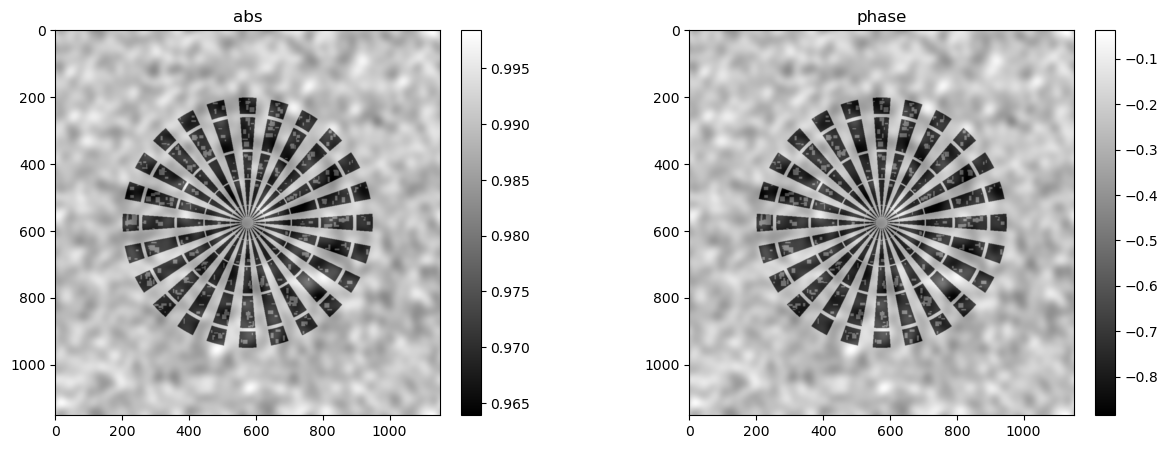

In [5]:
img = np.zeros((nobj, nobj, 3), np.uint8)
triangle = np.array([(nobj//16, nobj//2-nobj//32), (nobj//16, nobj//2+nobj//32), (nobj//2-nobj//64, nobj//2)], np.float32)
star = img[:,:,0]*0
for i in range(0, 360, 15):
    img = np.zeros((nobj, nobj, 3), np.uint8)
    degree = i
    theta = degree * np.pi / 180
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]], np.float32)    
    rotated = cv2.gemm(triangle-nobj//2, rot_mat, 1, None, 1, flags=cv2.GEMM_2_T)+nobj//2
    cv2.fillPoly(img, [np.int32(rotated)], (255, 0, 0))
    star+=img[:,:,0]
[x,y] = np.meshgrid(np.arange(-nobj//2,nobj//2),np.arange(-nobj//2,nobj//2))
x = x/nobj*2
y = y/nobj*2
# add holes in triangles
circ = (x**2+y**2>0.145)+(x**2+y**2<0.135)
circ *= (x**2+y**2>0.053)+(x**2+y**2<0.05)
circ *= (x**2+y**2>0.0085)+(x**2+y**2<0.008)
circ *= (x**2+y**2>0.32)+(x**2+y**2<0.3)

circ *= (x**2+y**2<0.65**2)
bg =np.random.random(star.shape)-0.5
v = np.arange(-nobj//2,nobj//2)/nobj
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-4000*(vx**2+vy**2))
bg = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(bg)))
bg = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(bg*v))).real


star = star/255
star*=circ



# add rectangles randomly
nrect = 400
max_size = 16
min_size = 3
import random
irect=0
for _ in range(10000):
    x = random.randint(0, nobj)
    y = random.randint(0, nobj)
    width = random.randint(min_size, max_size)
    height = random.randint(min_size, max_size)

    # Ensure the rectangle stays within bounds
    if x + width > nobj:
        width = nobj-x
    if y + height > nobj:
        height = nobj-y
    
    if np.sum(star[y:y+height,x:x+width]>0)==height*width:
        star[y:y+height,x:x+width]=0.5
        irect+=1
        # print(irect)
    if irect==nrect:
        break
bg-=np.min(bg)
star += bg*20
# star[star<0]=0
# smooth
v = np.arange(-nobj//2,nobj//2)/nobj
[vx,vy] = np.meshgrid(v,v)
v = np.exp(-10*(vx**2+vy**2))
fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(star)))
star = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v))).real

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)

thickness = 1e-6/voxelsize # siemens star thickness in pixels
# form Transmittance function
u = star*(-delta+1j*beta) # note -delta
Ru = u*thickness 
psi = np.exp(1j * Ru * voxelsize * 2 * np.pi / wavelength).astype('complex64')

mshow_polar(psi,show)

File ‘../data/prb_id16a/prb_abs_2048.tiff’ already there; not retrieving.

File ‘../data/prb_id16a/prb_phase_2048.tiff’ already there; not retrieving.



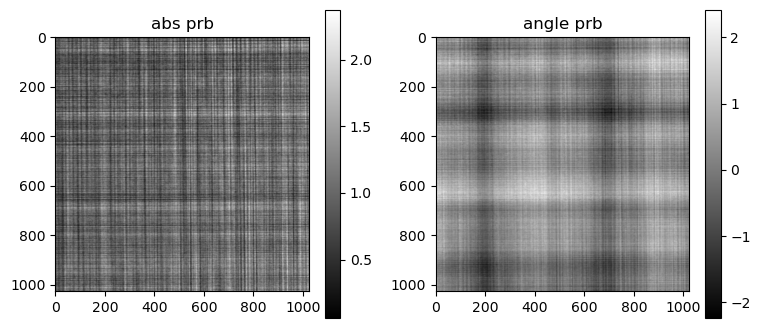

In [6]:
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P ../data/prb_id16a
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P ../data/prb_id16a

prb_abs = dxchange.read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0]
prb_phase = dxchange.read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')

prb = prb[1024-nprb//2:1024+nprb//2,1024-nprb//2:1024+nprb//2]
prb /= np.mean(np.abs(prb))

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb),cmap='gray')
axs[0].set_title('abs prb')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb),cmap='gray')
axs[1].set_title('angle prb')
fig.colorbar(im)

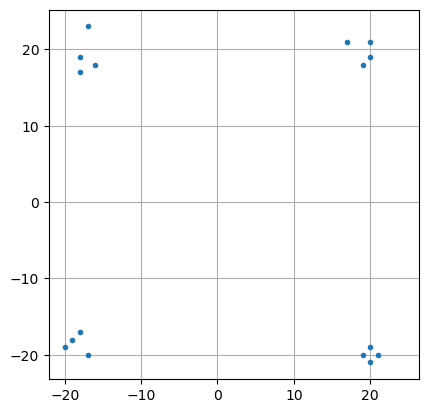

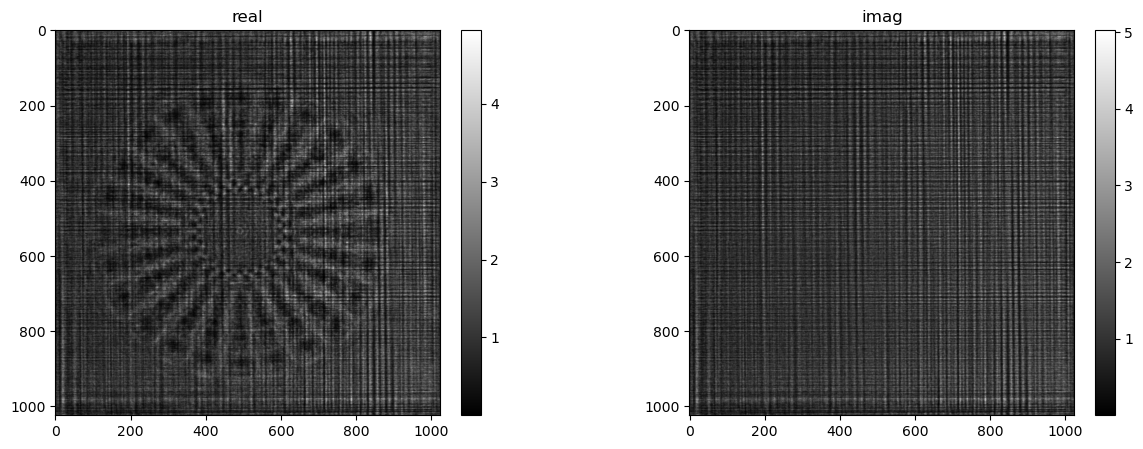

In [11]:
import h5py
with h5py.File(f'/data/vnikitin/ESRF/ID16A/20240924/SiemensLH/SiemensLH_010nm_nfp_01/SiemensLH_010nm_nfp_010000.h5','r') as fid:
    spz = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spz']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize
    spy = np.array(str(np.array(str(np.array(fid['/entry_0000/instrument/PCIe/header/spy']))[1:]))[1:-1].split(' '),dtype='float32')*1e-6/voxelsize

shifts = np.zeros([npos,2],dtype='float32')
shifts[:,1] = spy[:npos]
shifts[:,0] = -spz[:npos]
shifts/=4
shifts[4]+=1
shifts[3]-=1
shifts = np.round(shifts).astype('float32')
plt.plot(shifts[:,0],shifts[:,1],'.')
plt.axis('square')
plt.grid()
plt.show()

shifts = cp.array(shifts)
ishifts = cp.round(shifts).astype('int32')
fshifts = (shifts-ishifts).astype('float32')
psi = cp.array(psi)
prb = cp.array(prb)
data = np.abs(Lop(prb*Sop(psi,ishifts,fshifts,extra)))**2
ref = np.abs(Lop(prb*(1+0*Sop(psi*0+1,ishifts,fshifts,extra))))**2
ref = ref[0]

rdata = data/(ref+1e-11)
mshow_complex(data[0]+1j*ref,show)#,show,vmax=1.3,vmin=0.8)

In [12]:
np.save(f'{path}/data/data',data.get())
np.save(f'{path}/data/ref',ref.get())
np.save(f'{path}/data/gen_prb',prb.get())
np.save(f'{path}/data/gen_shifts',shifts.get())
np.save(f'{path}/data/psi',psi.get())


# add ververy low noise to avoid numerical precision errors

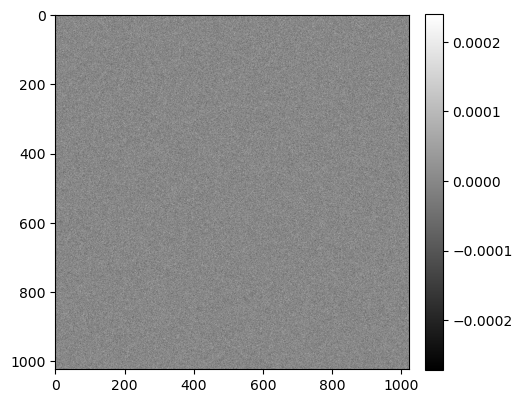

In [14]:
std_dev = 0.00005  # Standard deviation of the noise

# Generate Gaussian noise
noise = cp.random.normal(0, std_dev, size=data.shape).astype('float32')
ndata = data+noise
ndata[ndata<np.amin(data)]=np.amin(data)
np.save(f'{path}/data/data',ndata.get())
mshow(data[0]-ndata[0],show)


/data/vnikitin/paper/near_field/data/ndata


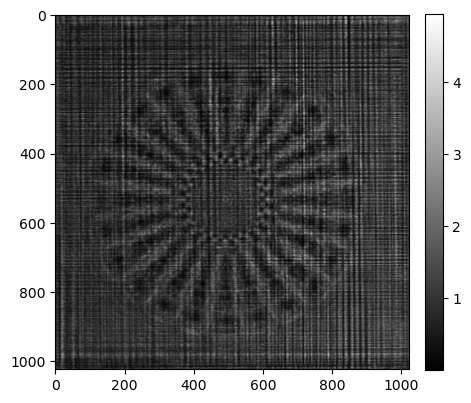

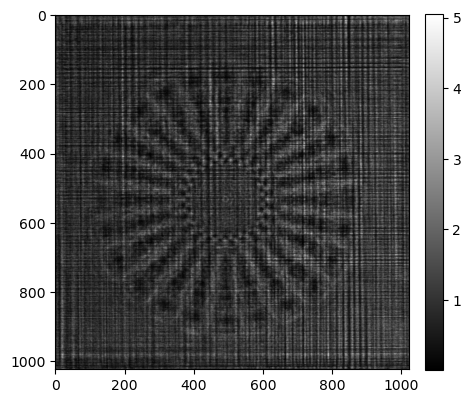

3.9729744e-06
3.9729744e-06


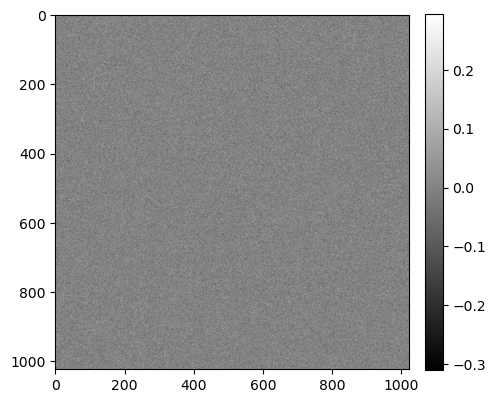

In [17]:
std_dev = 0.065  # Standard deviation of the noise

# Generate Gaussian noise
noise = cp.random.normal(0, std_dev, size=data.shape).astype('float32')
ndata = data+noise

ndata[ndata<np.amin(data)]=np.amin(data)
np.save(f'{path}/data/ndata',ndata.get())
print(f'{path}/data/ndata')
mshow(data[0],show)
mshow(ndata[0],show)
print(np.amin(data))
print(np.amin(ndata))
mshow(data[0]-ndata[0],show)

In [18]:
shifts_random = shifts.get()+6*(np.random.random([npos,2])-0.5)
shifts_random = shifts_random.astype('float32')
np.save(f'{path}/data/gen_shifts_random',shifts_random)